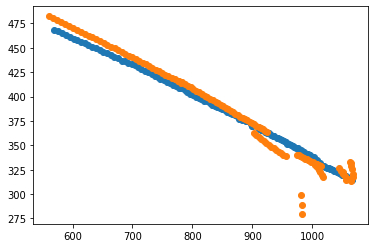

In [3]:
import cv2
import numpy as np
import glob

            
def update(x, P, Z, H, R):
    y = Z -np.dot(H, x)
    S = np.dot(np.dot(H, P), np.transpose(H)) + R
    K = np.dot(np.dot(P, np.transpose(H)), np.linalg.pinv(S))
    return [x + np.dot(K, y), np.dot((np.eye(x.shape[0]) - np.dot(K, H)), P)]    
    
def predict(x, P, F, u):
    return [np.dot(F, x) + u, np.dot(np.dot(F, P), np.transpose(F))]

def initialize():  
    ### Initialize Kalman filter ###
    # The initial state (6x1).
    # The initial state. The robot starts in position 0 with the velocity 0.
    x = np.array([[0], # Position along the x-axis
                  [0], # Velocity along the x-axis
                  [0], # Position along the y-axis   
                  [0], # Velocity along the y-axis
                  [0], # Position along the z-axis
                  [0]])# Velocity along the z-axis

    # The initial uncertainty (6x6).
    P = np.array([[1000, 0, 0, 0, 0, 0],
                  [0, 1000, 0, 0, 0, 0],
                  [0, 0, 1000, 0, 0, 0],
                  [0, 0, 0, 1000, 0, 0],
                  [0, 0, 0, 0, 1000, 0],
                  [0, 0, 0, 0, 0, 1000]])

    # The external motion (6x1).
    u = np.array([[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]])

    # The transition matrix (6x6). 
    F = np.array([[1, 1, 0.5, 0, 0, 0],
                  [0, 1, 1,   0, 0, 0], 
                  [0, 0, 1,   0, 0, 0],
                  [0, 0, 0,   1, 1, 0.5],
                  [0, 0, 0,   0, 1, 1],
                  [0, 0, 0,   0, 0, 1]])
    """
    F = np.array([[1, 1, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0], 
                  [0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1],
                  [0, 0, 0, 0, 0, 1]])
    """
    # The observation matrix (2x6).
    H = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0]])

    #H = np.array([[1, 0, 0, 0, 0, 0],
    #              [0, 0, 1, 0, 0, 0],
    #              [0, 0, 0, 0, 1, 0]])

    # The measurement uncertainty.
    R = 1
    
    return x, u, F, P, R, H

def beltmask(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return cv2.bitwise_not(cv2.inRange(hsv, np.array([100,50,50]), np.array([115,255,255])))

def objectmask(frame, bgs):
    fgMask = bgs.apply(frame)

    kernel = np.ones((5,5), np.uint8) 

    fgMask = cv2.dilate(fgMask, kernel, iterations=1) 

    contours, _ = cv2.findContours(fgMask,2,1)            
    contours = sorted(contours, key=cv2.contourArea)            
    out_mask = np.zeros_like(fgMask)
    cv2.drawContours(out_mask, [contours[-1]], -1, 255, cv2.FILLED, 1)  
    return out_mask

def findobjectbounds(mask):
    contours, _ = cv2.findContours(mask,2,1)   
    c = max(contours, key=cv2.contourArea)
    ((center_x, center_y), radius) = cv2.minEnclosingCircle(c)
    return center_x, center_y, radius


x, u, F, P, R, H = initialize()

leftImages = glob.glob('./left/*.png')
frame = cv2.imread(leftImages[0])

backSub = cv2.createBackgroundSubtractorMOG2(30, 16, False)
_ = backSub.apply(frame)

measure_history = []
prediction_history = []
for i, img in enumerate(leftImages[1:]):
    frame = cv2.imread(img)

    center_x, center_y = 0, 0
    
    object_mask = objectmask(frame, backSub)
    belt_mask = beltmask(frame)

    res = cv2.bitwise_and(object_mask, object_mask, mask=belt_mask)
    
    center_x, center_y, radius = findobjectbounds(res)
    
    
    measure_history.append((center_x, center_y))
    frame = cv2.addWeighted(frame, 1, cv2.bitwise_and(frame,frame,mask = res), 1, 0)
    cv2.circle(frame, (int(center_x), int(center_y)), int(radius), (0, 0, 255), 2) #cirle
    for c_x, c_y in measure_history:
        cv2.circle(frame, (int(c_x), int(c_y)), 1, (0, 255, 255), -1) #center
    cv2.circle(frame, (int(measure_history[-1][0]), int(measure_history[-1][1])), 5, (0, 0, 255), -1) #center
    
    
    if center_x != 0 and center_y != 0:
        z = np.array([[center_x],
                      [center_y]])
        #print(z)
        [x, P] = update(x, P, z, H, R) 
    else:
        print("not detected")
        
    ### Predict the next state
    [x, P] = predict(x, P, F, u)
    #print(x)
    
    ### Draw the current tracked state and the predicted state on the image frame ###
    x_pred, y_pred = np.matmul(H, x).ravel()
    prediction_history.append((x_pred, y_pred))
    cv2.circle(frame,(int(x_pred), int(y_pred)), 5, (255,0,0),-1)
    
    # Show the frame
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)

cv2.destroyAllWindows()


import matplotlib.pyplot as plt
x_meas = [i[0] for i in measure_history]
y_meas = [i[1] for i in measure_history]
x_pred = [i[0] for i in prediction_history]
y_pred = [i[1] for i in prediction_history]
plt.scatter(x_meas, y_meas)
plt.scatter(x_pred, y_pred)
plt.show()